# Project Preparation 

In [13]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
import requests
import matplotlib.cm as cm




### Dynamic stock data fetcher

Stock fetcher extracts the current Wikipedia list of all S&P 500 companies


In [14]:

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    
    # The relevant table containing S&P 500 information is typically the first one
    sp500_table = df_list[0]
    
    # Extracting the columns of interest
    sp500_data = sp500_table[['Symbol', 'Security']]
    
    return sp500_data

# Call the function to get the S&P 500 data
sp500_data = get_sp500_tickers()
companies_dict = sp500_data.set_index('Symbol').to_dict()['Security']

# Display the data
print(len(companies_dict))
tickers = list(companies_dict.keys())


503


### Data wrangling

Exploring the data, preparing it and cleaning it

In [15]:
# Reading data from the given csv file
data = pd.read_csv('SP500_prices.csv')

# Data cleaning - removing columns with company names not in S&P 500
for c in data.columns[1:]:
    if c not in tickers:
        data = data.drop([c], axis=1)

# Data cleaning - datatype conversion and date filtering
data.date = pd.to_datetime(data.date)
data = data[data.date > "2018"]
data.index = data["date"]
data.drop(columns=["date"],inplace=True)        

# Print the data
data.head()

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667


Analysis will be conducted on daily returns

In [16]:
returns_1_day = data.pct_change()

# Removing the first row of NaN values due to pct_change functio
returns_1_day = returns_1_day.iloc[1:,:]

# Check for missing values in returns_1_day
missing_values = returns_1_day.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print("Columns with Missing Values:")
print(columns_with_missing_values)

# Display total number of missing values in each column
print("\nTotal Number of Missing Values in Each Column:")
print(missing_values)

# Print missing vlues in csv file
missing_values.to_csv('missing.csv')

# As we can see, there are columns with missing values, we will drop them
returns_1_day.dropna(axis=1,inplace=True)

Columns with Missing Values:
CARR     556
CDAY      79
CEG     1019
CTVA     350
DOW      304
FOX      299
FOXA     298
MRNA     235
OTIS     556
dtype: int64

Total Number of Missing Values in Each Column:
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 473, dtype: int64


Let us print out two stocks that have historically performed similarly (just by trying out couple pairs)

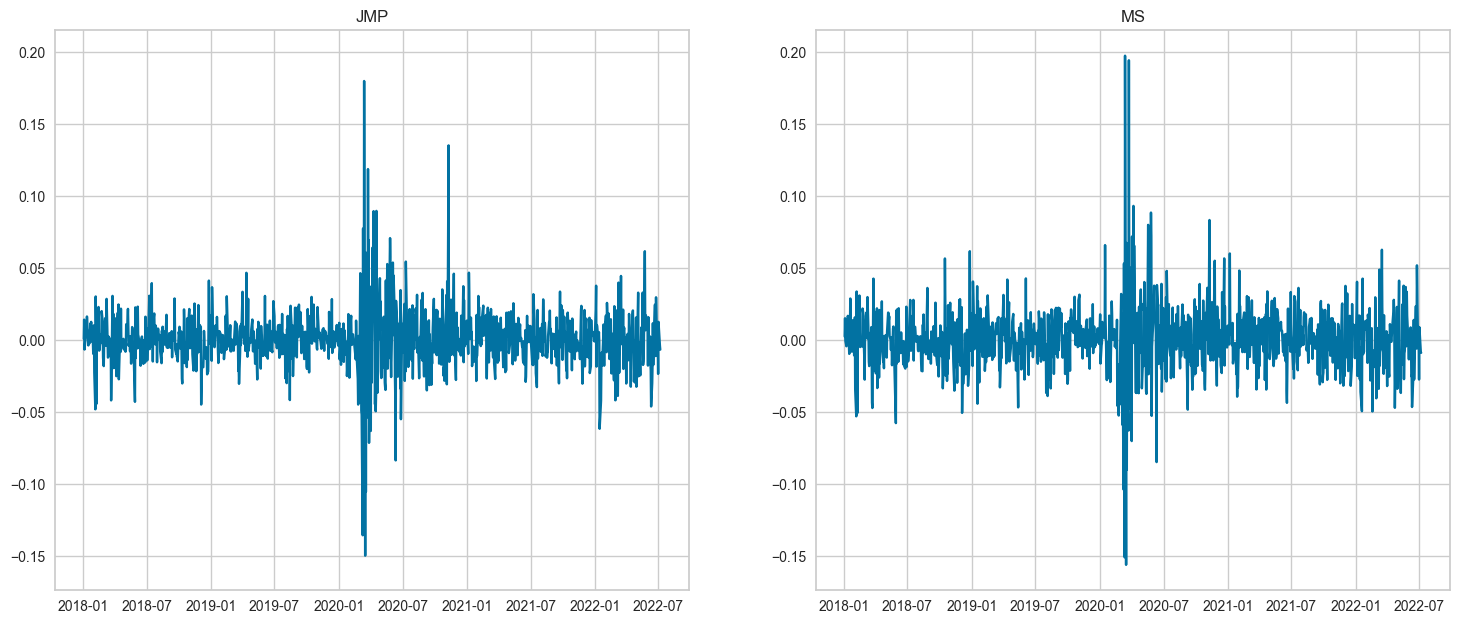

In [17]:
# Chose two well known stocks in the same industry group (JPM and MS both banking sektor)

plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(returns_1_day["JPM"])
plt.title("JMP")

plt.subplot(222, sharey=ax1)
plt.plot(returns_1_day["MS"])
plt.title("MS")
plt.show()

For clustering we need to change our dataframe to be suitable to our algorithms

In [18]:
ret_T = returns_1_day.T

ret_T = pd.DataFrame(ret_T)
ret_T.index.name = 'stock'
ret_T.head()

date,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2022-06-22,2022-06-23,2022-06-24,2022-06-27,2022-06-28,2022-06-29,2022-06-30,2022-07-01,2022-07-05,2022-07-06
stock,,,,,,,,,,,,,,,,,,,,,
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011653,...,-0.000702,0.042179,0.022681,-0.005936,-0.029112,0.007176,0.007379,0.005482,0.011325,0.005143
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,0.004601,-0.009160,0.070878,-0.024460,-0.004425,-0.034815,-0.026861,0.035489,0.057121,0.000720
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000114,-0.000230,0.005680,0.010326,-0.005082,0.016516,...,-0.003827,0.021574,0.024517,0.000000,-0.029790,0.013024,-0.018028,0.016164,0.018930,0.009607
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007539,-0.005487,0.002930,0.010779,0.021427,0.018246,...,0.028508,0.012808,0.019338,0.005251,-0.004244,0.010820,-0.006358,0.004179,0.000845,-0.009095
ABT,0.002211,-0.001697,0.002890,-0.002882,0.001700,-0.001527,0.006832,-0.001866,-0.006798,0.009411,...,0.009865,0.007303,0.030506,-0.003380,-0.019344,0.019912,-0.004125,0.014450,-0.008347,-0.005581


To optain the right amount of dumentionality reduction without looksing too much variance/information we will use the pareto principal

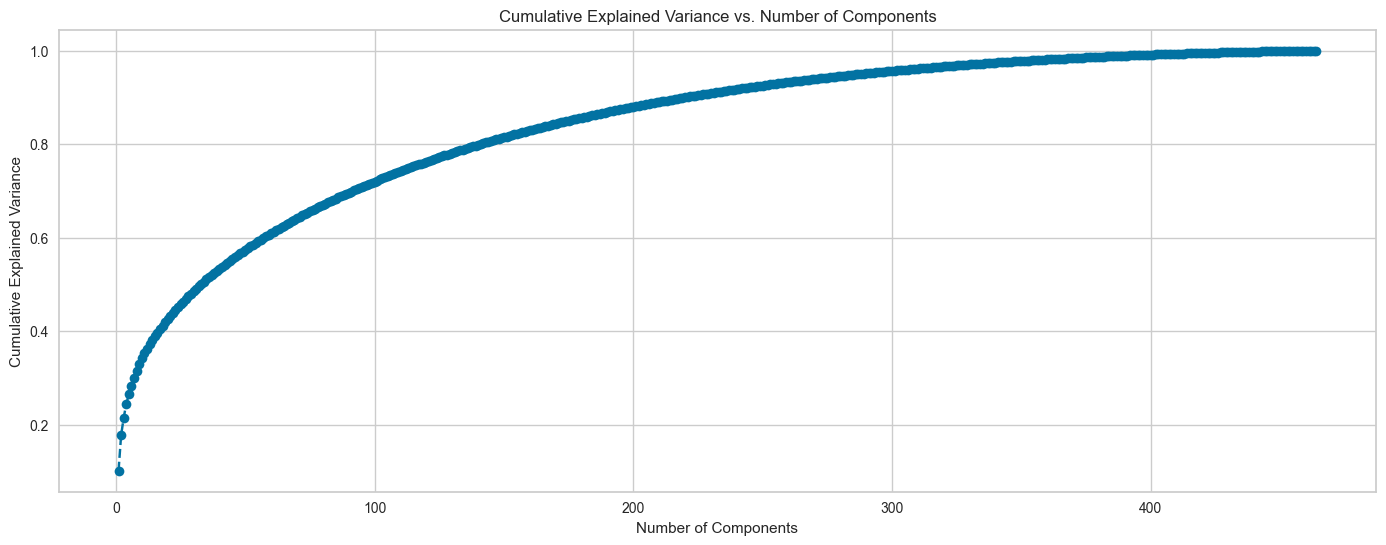

91 components needed to explain 70% of the variance
140 components needed to explain 80% of the variance
219 components needed to explain 90% of the variance


In [19]:
# Standardize the Data improve the robustness and performance of your models 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ret_T)

# PCA Dimensionality Reduction
pca = PCA(random_state=1)
pca.fit(scaled_data)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(17, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Check the number of components needed to explain 70% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.7:
        print(str(i) + " components needed to explain 70% of the variance")
        break

# Check the number of components needed to explain 80% of the variance <-- we choose this as the pareto optimum component
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.8:
        print(str(i) + " components needed to explain 80% of the variance")
        n_components = i
        break

# Check the number of components needed to explain 90% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.9:
        print(str(i) + " components needed to explain 90% of the variance")
        break

Do the PCA and print out our new dataframe with a component reduction of >60%

In [20]:
pca = PCA(n_components=n_components, random_state=1)
principal_components = pca.fit_transform(scaled_data)

# principal_components as a dataframe
principal_components = pd.DataFrame(principal_components)

print("Shape of principal_components: " + str(principal_components.shape))
principal_components.head()


Shape of principal_components: (464, 140)


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-5.414068,8.703627,2.684238,-2.932101,-3.585595,-0.900673,-1.150832,0.078742,4.916834,3.734660,...,-2.007286,-0.728399,1.177486,-0.106075,1.100344,-0.709096,2.472255,0.325788,-0.990783,0.134943
1,26.280791,0.242297,-23.855849,10.238739,0.492459,-4.776185,-8.459733,9.200511,1.785592,-8.165206,...,-0.009131,3.182026,-0.017280,0.225110,0.836452,0.138794,-0.297909,1.560386,-0.812560,0.043457
2,-3.721772,13.751482,2.847328,0.865999,2.178101,-2.006725,-0.446832,-0.002476,-2.367879,-2.067219,...,1.387722,-1.703679,-2.062532,1.323078,-1.530393,0.301039,0.844645,0.079201,0.058326,1.887883
3,-7.452531,-2.226275,6.325372,-3.594179,-4.084265,-4.467822,-3.256562,5.351949,-0.433359,3.083636,...,-1.876317,-0.048780,-2.099741,-1.022716,1.670592,0.922679,3.974213,3.287604,-1.221050,-2.118814
4,-10.381086,4.719474,3.246369,-3.066251,-4.940218,-3.726870,-1.617164,2.177926,2.489307,2.945008,...,0.690586,0.036433,1.657231,0.273563,0.062658,-0.077978,0.324113,-1.691080,1.587700,0.266601


### Clustering Analysis

[...] The final method of choice, after conducting a rudimentary heatmap and full KMeans clustering, is DBSCAN

In [21]:
eps_value = 15
min_samples_value = 5

clf = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clf.fit(principal_components)

# Extract cluster labels and remove noise points
labels = clf.labels_
clustered_mask = (labels != -1)
# print(clustered_mask)
clustered_data = principal_components[clustered_mask]
clustered_labels = labels[clustered_mask]

# Calculate the number of clusters (excluding noise)
n_clusters_ = len(set(clustered_labels))
# Calculate the number of noise points
n_noise_ = len(labels) - len(clustered_data)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Calculate silhouette score for clustered data
silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)
print(f"Silhouette Coefficient (excluding noise): {silhouette_avg:.3f}")

Estimated number of clusters: 4
Estimated number of noise points: 353
Silhouette Coefficient (excluding noise): 0.278


Silhouette Coefficient is already quite good but lets try to improve it by tuning the hyperparameters!

In [22]:

eps_values = np.arange(5, 30, 0.1)
min_samples_values = list(range(3, 10))  # We want to test min_samples values starting 2

best_eps = None
best_min_samples = None
best_silhouette_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        clf = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clf.fit_predict(principal_components)
        unique_labels = set(labels)

        if len(unique_labels) <= 4 or len([label for label in labels if label != -1]) <= 120:  # We want at least 4 clusters
            pass
        else:
            clustered_mask = (labels != -1)
            clustered_data = principal_components[clustered_mask]
            clustered_labels = labels[clustered_mask]

            # Calculate silhouette score
            silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)

            # Update best parameters if silhouette score is higher
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette_score}")

# Fit DBSCAN with best parameters
best_clf = DBSCAN(eps=best_eps, min_samples=best_min_samples)

best_labels = best_clf.fit_predict(principal_components)
n_clusters_ = len(set(best_labels)) - (1 if -1 in best_labels else 0)

# This is used to make it unifrom with the previous code (I'll make it more unform later when we submit the code)
clustered = best_clf.labels_


best_clustered_mask = (best_labels != -1)
best_clustered_data = principal_components[best_clustered_mask]
best_clustered_labels = best_labels[best_clustered_mask]

n_noise_ = list(best_labels).count(-1)

clustered_series = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Silhouette Coefficient: {best_silhouette_score:.3f}")


Best eps: 13.899999999999968
Best min_samples: 3
Best Silhouette Score: 0.3380043702458983
Estimated number of clusters: 15
Estimated number of noise points: 340
Silhouette Coefficient: 0.338


Let us visualize the clusters we just created

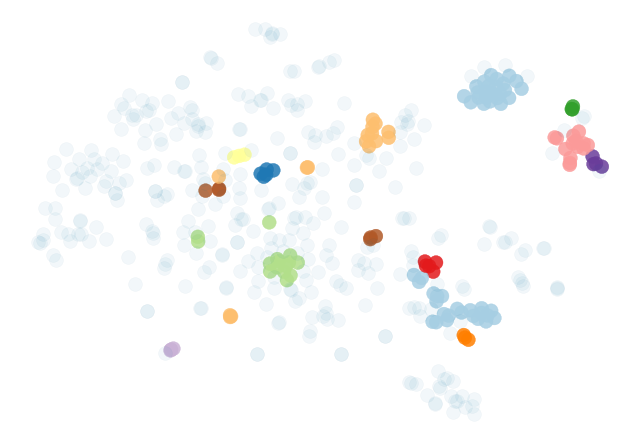

In [26]:
plt.figure(1, facecolor='white')
plt.clf()

plt.scatter(
    tsne_result[(clustered!=-1), 0],
    tsne_result[(clustered!=-1), 1],
    s=100,
    alpha=0.85,
    c=clustered[clustered!=-1],
    cmap=cm.Paired
)

plt.scatter(
    tsne_result[(clustered_series_all==-1).values, 0],
    tsne_result[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

#plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.axis("off")
plt.savefig('DBSCAN_cluster.svg',format='svg', bbox_inches='tight')
plt.show()

# print(tsne_result)


And also print out the names of the clusters

In [24]:
DBSCAN_cluster =[]
# print out the stock names that are in each cluster
for i in range(len(ticker_count_reduced)):
    print("Cluster " + str(i+1) + " (" + str(len(clustered_series[clustered_series==i])) + " stocks)")
    for name in clustered_series[clustered_series==i].index:
        print(companies_dict[name], end=", ")
        DBSCAN_cluster.append({"Cluster": i,"Stock":name,"Stock_Name":companies_dict[name]})
    print("\n")
    # print(clustered_series[clustered_series==i].index.tolist())
    # print(", ".join(clustered_series[clustered_series==i].index.tolist()))
    # print()


Cluster 1 (24 stocks)
Ameren, American Electric Power, Atmos Energy, American Water Works, CMS Energy, CenterPoint Energy, Dominion Energy, DTE Energy, Duke Energy, Consolidated Edison, Eversource, Entergy, Evergy, Exelon, Alliant Energy, NextEra Energy, NiSource, Public Service Enterprise Group, Pinnacle West, PPL Corporation, Southern Company, Sempra Energy, WEC Energy Group, Xcel Energy, 

Cluster 2 (23 stocks)
Aflac, Ameriprise Financial, Bank of America, Citigroup, Citizens Financial Group, Comerica, Fifth Third Bank, Globe Life, Goldman Sachs, Huntington Bancshares, JPMorgan Chase, KeyCorp, Loews Corporation, MetLife, Morgan Stanley, M&T Bank, Principal Financial Group, PNC Financial Services, Prudential Financial, Regions Financial Corporation, Truist, U.S. Bank, Zions Bancorporation, 

Cluster 3 (5 stocks)
Arthur J. Gallagher & Co., Aon, Brown & Brown, Marsh McLennan, Willis Towers Watson, 

Cluster 4 (15 stocks)
Ametek, Amphenol, Dover Corporation, Emerson Electric, Eaton Corp